#Prep

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Project


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import os
from keras.layers import Layer
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.keras.layers import Input, Layer, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, GaussianNoise, Lambda, InputLayer
from tensorflow.keras.layers import concatenate, ZeroPadding2D, Cropping2D, Reshape, Flatten, SpatialDropout2D, Softmax, Embedding, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import gym

Using TensorFlow backend.


In [0]:
from keras.utils import plot_model

In [0]:
env = gym.make('MsPacman-v0')

In [0]:
import cv2
imgs = []
for i_episode in range(10):
    observation = env.reset()
    for t in range(1000):
        imgs.append(cv2.resize(env.env.ale.getScreenRGB(), (84,84)))
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

Episode finished after 879 timesteps
Episode finished after 742 timesteps
Episode finished after 665 timesteps
Episode finished after 660 timesteps
Episode finished after 518 timesteps
Episode finished after 800 timesteps
Episode finished after 659 timesteps
Episode finished after 713 timesteps
Episode finished after 589 timesteps
Episode finished after 738 timesteps


In [0]:
x_imgs = np.array(imgs)
x_imgs = x_imgs.astype('float32')
x_imgs /= 255
train = x_imgs[:len(imgs)*8//10]
val = x_imgs[len(imgs)*8//10:]

In [0]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image, save=False, i=0):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if save:
      plt.savefig(str(i) + '.png')

def save_image(image, pred, i=0):
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax1.imshow(image, cmap="binary")
    ax2.imshow(pred, cmap="binary")
#    plt.show()
#    plt.axis("off")
    plt.savefig(str(i) + '.png')

In [0]:
#UNet Loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def elastic(y_true, y_pred):
  l = 0.1
  return K.mean(K.square(y_true - y_pred) + l * K.abs(y_true - y_pred))

In [0]:
opt = keras.optimizers.Nadam()

#Model

In [0]:
inputs = Input(shape=[84,84,3], name="Input")
x = inputs
x1 = Conv2D(8, 3, strides=1, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x2 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(2,1), activation='selu', kernel_initializer='he_normal')(x)
x3 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(1,2), activation='selu', kernel_initializer='he_normal')(x)
x4 = Conv2D(8, 3, strides=1, padding='same', dilation_rate=(2,2), activation='selu', kernel_initializer='he_normal')(x)
x = concatenate([x1, x2, x3, x4])
x = BatchNormalization()(x)
x = Conv2D(32, 5, strides=2, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 5, strides=2, padding='same', activation='selu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
eo = Dense(256, activation='selu')(x)
enc = Model(inputs=inputs, outputs=eo)

dec = Sequential([
                  Dense(256, activation='selu', input_shape=(256,), kernel_initializer='he_normal'),
                  Dropout(0.1),
                  Dense(512, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.1),
                  Dense(256, activation='selu', kernel_initializer='he_normal'),
                  Dropout(0.1),
                  Dense(84*84*3, activation='selu'),
                  Reshape((84,84,3)),
                  Conv2DTranspose(128, 3, padding='same', activation='selu'),
                  BatchNormalization(),
                  Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
])
ae = Sequential([enc, dec])

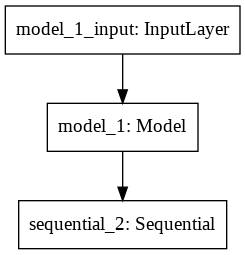

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(ae, to_file='model.png')

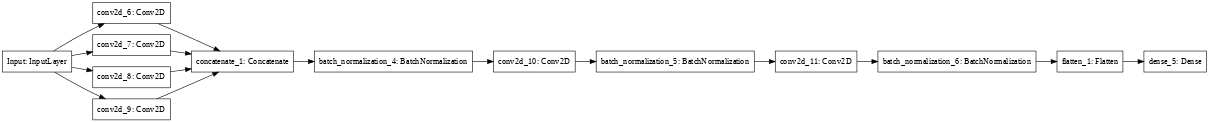

In [0]:
plot_model(enc, to_file='enc.png', rankdir='LR', dpi=42)

In [0]:
plot_model(dec, to_file='dec.png', dpi=36, show_shapes=False, rankdir='LR')

In [0]:
enc.compile(loss='mse')
enc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 84, 84, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 84, 84, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 84, 84, 8)    224         input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
dec.compile(loss='mse')
dec.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 21168)             5

In [0]:
ae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 256)               7303904   
_________________________________________________________________
sequential (Sequential)      (None, 84, 84, 3)         5776435   
Total params: 13,080,339
Trainable params: 13,079,827
Non-trainable params: 512
_________________________________________________________________


In [0]:
K.clear_session()
ae.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                  metrics=[rounded_accuracy])

In [0]:
ae.load_weights('/content/gdrive/My Drive/Project/results-99.68-38epoch.h5')

In [0]:
batch_size = 64
epochs = 200

In [0]:
history = ae.fit(train, train, epochs=epochs, batch_size=batch_size, validation_data=(val, val), shuffle=True)

Train on 54092 samples, validate on 13524 samples
Epoch 1/200
54092/54092 [==============================] - 235s 4ms/sample - loss: 0.0040 - rounded_accuracy: 0.9763 - val_loss: 0.0013 - val_rounded_accuracy: 0.9846
Epoch 2/200
54092/54092 [==============================] - 226s 4ms/sample - loss: 9.9647e-04 - rounded_accuracy: 0.9916 - val_loss: 9.2095e-04 - val_rounded_accuracy: 0.9932
Epoch 3/200
54092/54092 [==============================] - 225s 4ms/sample - loss: 8.1560e-04 - rounded_accuracy: 0.9930 - val_loss: 8.5591e-04 - val_rounded_accuracy: 0.9937
Epoch 4/200
54092/54092 [==============================] - 225s 4ms/sample - loss: 7.3199e-04 - rounded_accuracy: 0.9934 - val_loss: 7.9561e-04 - val_rounded_accuracy: 0.9891
Epoch 5/200
54092/54092 [==============================] - 224s 4ms/sample - loss: 6.7973e-04 - rounded_accuracy: 0.9937 - val_loss: 7.7905e-04 - val_rounded_accuracy: 0.9920
Epoch 6/200
54092/54092 [==============================] - 224s 4ms/sample - loss: 

KeyboardInterrupt: ignored

In [0]:
ae.save('results.h5')

#Evaluate

In [0]:
pred = ae.predict(val)

In [0]:
%cd imgs

/content/gdrive/My Drive/Project/imgs


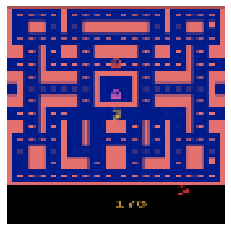

In [0]:
plot_image(pred[0], save=True, i=0)

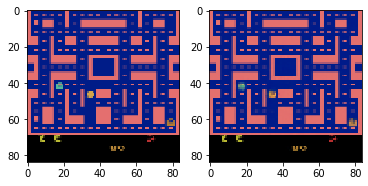

In [0]:
save_image(val[999], pred[999], 0)

In [0]:
for i, img in enumerate(pred):
  save_image(val[i], pred[i], i)

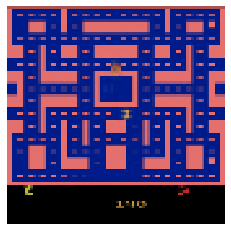

In [0]:
plot_image(pred[999])

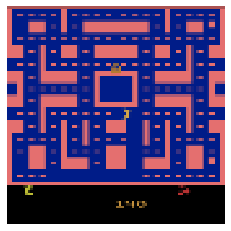

In [0]:
plot_image(val[999])

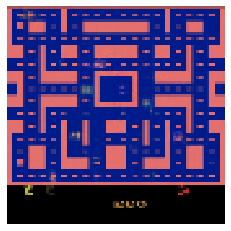

In [0]:
test = np.random.random((1,256))
test = dec.predict(test)
plot_image(test[0])

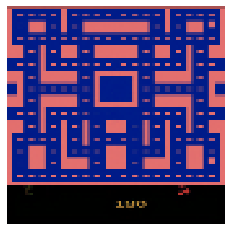

In [0]:
test = np.zeros((1,256))
test = dec.predict(test)
plot_image(test[0])

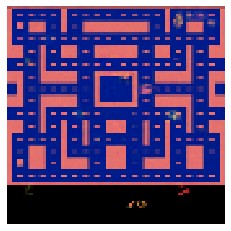

In [0]:
test = -np.ones((1,256))
test = dec.predict(test)
plot_image(test[0])

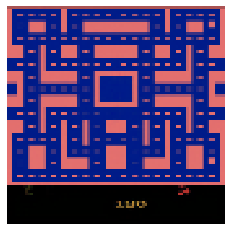

In [0]:
v = 240
test = np.zeros((1,256))
test[0][v] = 1
test = dec.predict(test)
plot_image(test[0])

In [0]:
test = enc.predict(val)

In [0]:
np.mean(test, axis=0)

array([ 4.23502512e-02,  9.06124059e-03,  2.79534534e-02,  2.32397579e-02,
        4.65606004e-02,  1.87114142e-02,  2.96441354e-02,  3.19997817e-02,
        1.00695282e-01,  2.51620921e-04,  5.06559573e-02,  1.68093398e-01,
        2.08644196e-02,  2.45883688e-02, -7.81747792e-03,  5.39213605e-02,
        2.85198856e-02,  1.44488374e-02,  1.20906662e-02, -3.88013176e-03,
        1.25513822e-02,  2.56354790e-02,  3.20133455e-02,  2.18925569e-02,
        2.27286741e-02, -7.11790146e-03,  1.76021196e-02,  1.01028249e-01,
       -5.81927039e-03, -2.27525574e-03,  8.42311978e-02, -4.17135730e-02,
        4.18749126e-03, -3.45509499e-02,  9.01879277e-03,  9.92287789e-03,
       -2.33910214e-02,  1.75312106e-02,  7.01570418e-03,  9.47222784e-02,
        1.10979257e-02,  1.29379481e-02,  6.72088563e-03,  1.84160378e-02,
       -2.73186881e-02,  2.04687864e-02,  1.54374793e-04,  3.53725329e-02,
        2.47579068e-02,  4.78554405e-02, -2.15829164e-02, -1.59342699e-02,
       -2.12584529e-02, -

In [0]:
np.std(test, axis=0)

array([0.12924092, 0.12024887, 0.110511  , 0.10307102, 0.15616657,
       0.10811789, 0.11759399, 0.09954275, 0.30852717, 0.10269222,
       0.15598293, 0.2764781 , 0.1238313 , 0.1335983 , 0.12589324,
       0.12219995, 0.11606768, 0.14129864, 0.1122236 , 0.12091874,
       0.11333871, 0.11991105, 0.11400378, 0.13662079, 0.12191942,
       0.28711805, 0.1579933 , 0.2791078 , 0.15181063, 0.14925049,
       0.13263163, 0.12637681, 0.10109972, 0.1298316 , 0.12476536,
       0.12029576, 0.13767125, 0.10528599, 0.11993661, 0.28224167,
       0.14909595, 0.16214667, 0.12988077, 0.11618228, 0.17029604,
       0.12256177, 0.11012203, 0.09818286, 0.12428662, 0.11543418,
       0.10709275, 0.11502565, 0.13279817, 0.15976445, 0.13378213,
       0.12771572, 0.140316  , 0.14673339, 0.12761693, 0.11705891,
       0.1244204 , 0.12327224, 0.10938535, 0.13653804, 0.1221512 ,
       0.11227562, 0.13254884, 0.1709827 , 0.3339899 , 0.13522597,
       0.1293835 , 0.26475742, 0.12704313, 0.14030536, 0.15486

In [0]:
x = [i for i in range(256)]

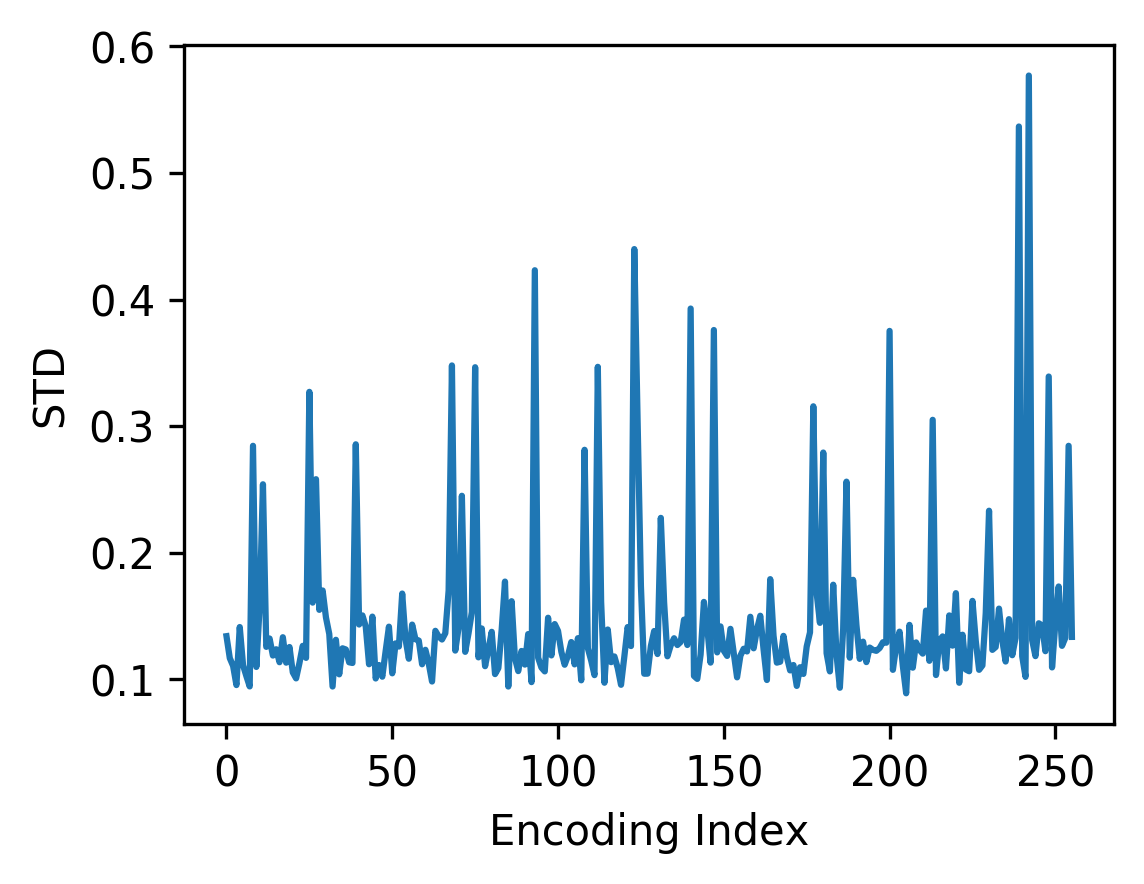

In [0]:
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel("Encoding Index")
plt.ylabel("STD")
plt.plot(x, np.std(test, axis=0))
plt.show()

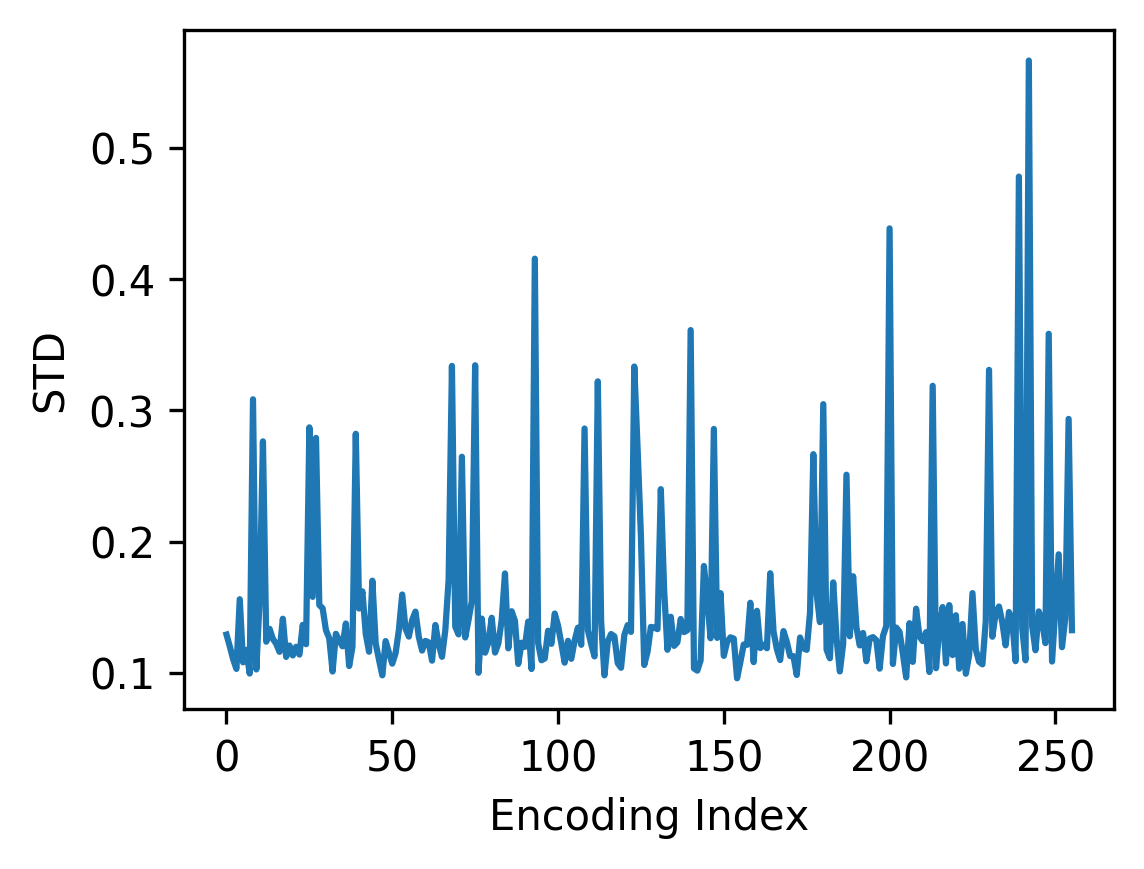

In [0]:
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel("Encoding Index")
plt.ylabel("STD")
plt.plot(x, np.std(test, axis=0))
plt.show()

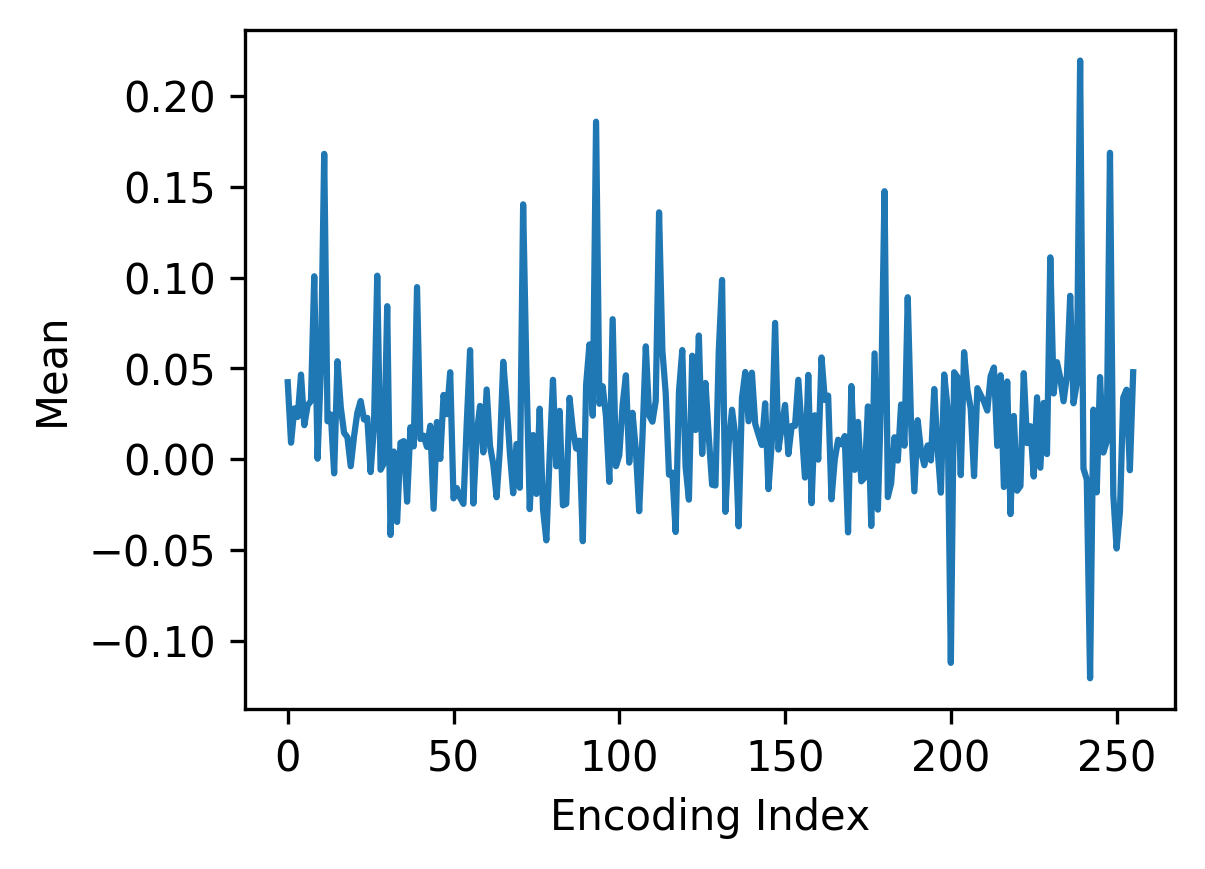

In [0]:
plt.figure(figsize=(4,3), dpi=300)
plt.xlabel("Encoding Index")
plt.ylabel("Mean")
plt.plot(x, np.mean(test, axis=0))
plt.show()

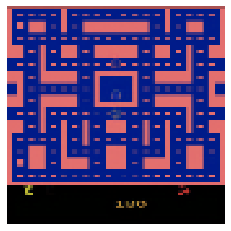

In [0]:
plot_image(dec.predict(np.mean(test, axis=0).reshape(1,256))[0])

In [0]:
neurons = [(s, m, i) for i, (s, m) in enumerate(zip(np.std(test, axis=0), np.mean(test, axis=0)))]

In [0]:
neurons = sorted(neurons, reverse=True)

In [0]:
neurons

In [0]:
tn = np.zeros((1,256))

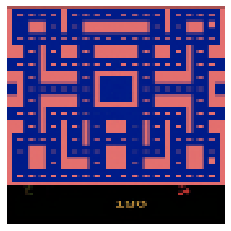

In [0]:
tn = np.zeros((1,256))
tn[0][neurons[0][2]] = neurons[0][1] + neurons[0][0]
plot_image(dec.predict(tn[0].reshape(1,256))[0])

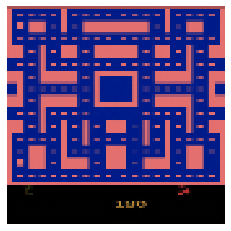

In [0]:
tn = np.zeros((1,256))
tn[0][neurons[0][2]] = neurons[0][1] - neurons[0][0]
plot_image(dec.predict(tn[0].reshape(1,256))[0])

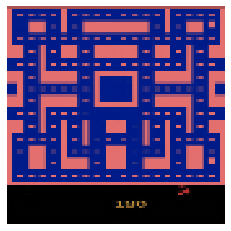

In [0]:
n = 1
tn = np.zeros((1,256))
tn[0][neurons[n][2]] = neurons[n][1] - neurons[n][0]
plot_image(dec.predict(tn[0].reshape(1,256))[0])

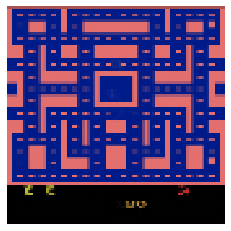

In [0]:
n = 1
tn = np.zeros((1,256))
tn[0][neurons[n][2]] = neurons[n][1] + neurons[n][0]
plot_image(dec.predict(tn[0].reshape(1,256))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


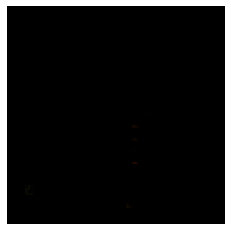

In [0]:
n = 210
tn = np.zeros((1,256))
tn[0][neurons[n][2]] = neurons[n][1] + neurons[n][0]
pos = dec.predict(tn[0].reshape(1,256))[0]
tn[0][neurons[n][2]] = neurons[n][1] - neurons[n][0]
neg = dec.predict(tn[0].reshape(1,256))[0]
plot_image(pos - neg)

In [0]:
for n in range (256):
  tn = np.zeros((1,256))
  tn[0][neurons[n][2]] = neurons[n][1] + neurons[n][0]
  pos = dec.predict(tn[0].reshape(1,256))[0]
  tn[0][neurons[n][2]] = neurons[n][1] - neurons[n][0]
  neg = dec.predict(tn[0].reshape(1,256))[0]
  im = pos - neg
  im -= np.min(im)
  im /= np.max(im)
  print(np.min(im), np.max(im))
  plt.imsave('neuron-' + str(n) + '.png', im)